#Scraping Data

In [ ]:
# Menginstall library untuk scraping, analisis data, dan model AI
!pip install google-play-scraper pandas torch transformers tqdm matplotlib seaborn -q
# === LANGKAH 1: SCRAPING  (4.000 DATA TERBARU) ===

import pandas as pd

from google_play_scraper import Sort, reviews
from tqdm.notebook import tqdm

# --- KONFIGURASI ---
APP_ID_TARGET = 'com.finaccel.android'
JUMLAH_TOTAL = 4000  # Total ulasan yang ingin diambil
NAMA_FILE_OUTPUT = '/content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_4k_terbaru.csv'
# --------------------

print(f"Memulai scraping untuk aplikasi: {APP_ID_TARGET}")
print(f"Target: {JUMLAH_TOTAL} ulasan terbaru secara keseluruhan.")
print("----------------------------------------------------")

# Tidak ada lagi loop per skor, kita langsung ambil semua
rvs, _ = reviews(
    APP_ID_TARGET,
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=JUMLAH_TOTAL,
    filter_score_with=None  # Set ke None untuk mengambil semua skor
)

df_baru = pd.DataFrame(rvs)

# Simpan hasil ke file CSV baru
df_baru.to_csv(NAMA_FILE_OUTPUT, index=False)

print("\n----------------------------------------------------")
print(f"SCRAPING SELESAI!")
print(f"Total {len(df_baru)} ulasan baru berhasil disimpan di:")
print(NAMA_FILE_OUTPUT)

Memulai scraping untuk aplikasi: com.finaccel.android
Target: 4000 ulasan terbaru secara keseluruhan.
----------------------------------------------------

----------------------------------------------------
SCRAPING SELESAI!
Total 4000 ulasan baru berhasil disimpan di:
/content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_4k_terbaru.csv


#Labeling

In [ ]:
# === PROSES LABELING UNTUK MEMBUAT KOLOM 'sentimen_teks' ===

import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm

# 1. Muat model AI (jika sesi dimulai ulang)
print("Memuat model sentimen...")
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model='w11wo/indonesian-roberta-base-sentiment-classifier'
)
print("Model berhasil dimuat!")

# 2. Muat data mentah hasil scraping
file_path_raw = '/content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_4k_terbaru.csv'
df = pd.read_csv(file_path_raw)
df = df[['content', 'score']].dropna() # Pilih kolom yang relevan & bersihkan

# 3. Membuat kolom 'label_skor' untuk perbandingan nanti
df['label_skor'] = df['score'].apply(lambda x: 'puas' if x >= 4 else 'netral' if x == 3 else 'tidak_puas')

# 4. Membuat kolom 'sentimen_teks' dari hasil analisis AI
print("\nMemulai analisis teks untuk membuat kolom 'sentimen_teks'...")
hasil_ai = []
label_map = {'positive': 'puas', 'negative': 'tidak_puas', 'neutral': 'netral'}

for text in tqdm(df['content']):
    try:
        result = sentiment_analyzer(text)
        mapped_label = label_map.get(result[0]['label'])
        hasil_ai.append(mapped_label)
    except Exception as e:
        hasil_ai.append('error')


df['sentimen_teks'] = hasil_ai

# 5. Simpan DataFrame akhir yang sudah dilabeli
file_path_labeled = '/content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_final_labeled.csv'
df.to_csv(file_path_labeled, index=False)

print(f"\nProses labeling selesai!")
print(f"Data akhir disimpan di: {file_path_labeled}")
display(df.head())

Memuat model sentimen...


Device set to use cpu


Model berhasil dimuat!

Memulai analisis teks untuk membuat kolom 'sentimen_teks'...


  0%|          | 0/4000 [00:00<?, ?it/s]


Proses labeling selesai!
Data akhir disimpan di: /content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_final_labeled.csv


,content,score,label_skor,sentimen_teks
0,turun limit - penolakan pengajuan sangat menge...,1,tidak_puas,puas
1,sukses selalu buat kridivo,5,puas,puas
2,ok,5,puas,tidak_puas
3,apk nya sangat membantu,5,puas,puas
4,mantap,5,puas,puas


In [1]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Tugas_Fintech/ulasan_kredivo_final_labeled.csv")

#EDA

#EDA Berdasarkan label_skor

/tmp/ipython-input-3-125762609.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_skor', data=df, palette='plasma', order=['puas', 'netral', 'tidak_puas'])


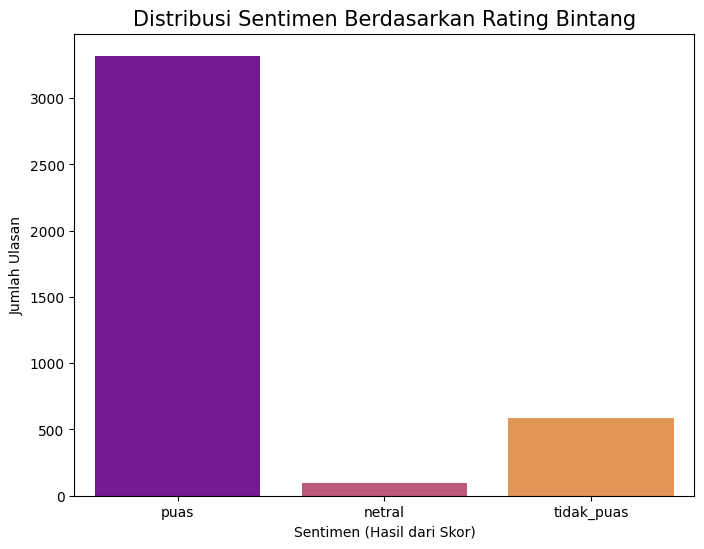

In [3]:
#EDA Berdasarkan label_skor
import matplotlib.pyplot as plt
import seaborn as sns

# (Asumsikan DataFrame 'df' sudah ada)

plt.figure(figsize=(8, 6))

sns.countplot(x='label_skor', data=df, palette='plasma', order=['puas', 'netral', 'tidak_puas'])

plt.title('Distribusi Sentimen Berdasarkan Rating Bintang', fontsize=15)
plt.xlabel('Sentimen (Hasil dari Skor)')
plt.ylabel('Jumlah Ulasan')
plt.show()

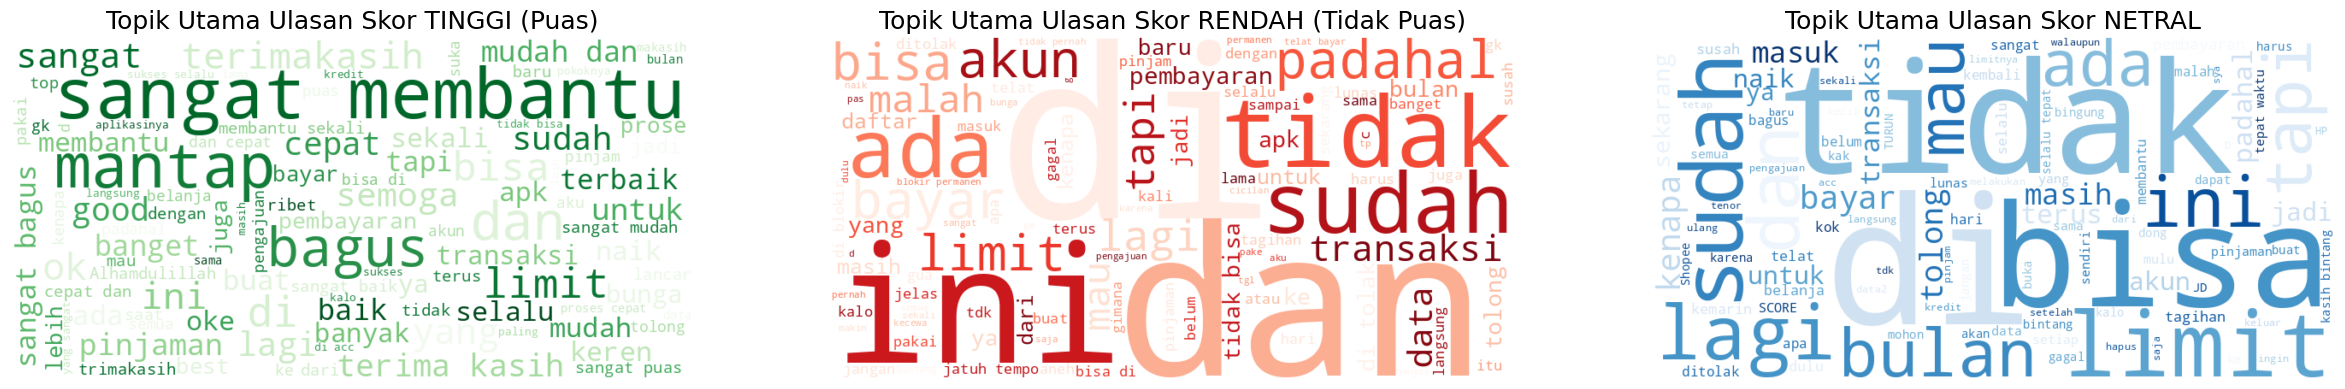

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# (Asumsikan DataFrame 'df' sudah ada dan memiliki kolom 'label_skor')

# Siapkan stopwords
stopwords_indonesia = set(STOPWORDS)
stopwords_indonesia.update(["yg", "ga", "gak", "aja", "sih", "nya", "klo", "udh", "udah", "sy", "saya", "aplikasi", "kredivo"])

# Pisahkan ulasan berdasarkan tiga sentimen dari skor
ulasan_puas_skor = " ".join(review for review in df[df['label_skor'] == 'puas']['content'])
ulasan_tidak_puas_skor = " ".join(review for review in df[df['label_skor'] == 'tidak_puas']['content'])
ulasan_netral_skor = " ".join(review for review in df[df['label_skor'] == 'netral']['content'])

# Siapkan kanvas untuk 3 gambar, perlebar ukuran figurnya
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

# Word Cloud untuk ulasan dengan SKOR TINGGI (Puas)
wordcloud_puas = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Greens', max_words=100, width=800, height=400).generate(ulasan_puas_skor)
ax1.imshow(wordcloud_puas, interpolation='bilinear')
ax1.set_title('Topik Utama Ulasan Skor TINGGI (Puas)', fontsize=18)
ax1.axis("off")

# Word Cloud untuk ulasan dengan SKOR RENDAH (Tidak Puas)
wordcloud_tidak_puas = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Reds', max_words=100, width=800, height=400).generate(ulasan_tidak_puas_skor)
ax2.imshow(wordcloud_tidak_puas, interpolation='bilinear')
ax2.set_title('Topik Utama Ulasan Skor RENDAH (Tidak Puas)', fontsize=18)
ax2.axis("off")

# Word Cloud untuk ulasan dengan SKOR NETRAL
wordcloud_netral = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Blues', max_words=100, width=800, height=400).generate(ulasan_netral_skor)
ax3.imshow(wordcloud_netral, interpolation='bilinear')
ax3.set_title('Topik Utama Ulasan Skor NETRAL', fontsize=18)
ax3.axis("off")

plt.show()

#EDA Berdasarkan Sentimen_teks

/tmp/ipython-input-5-734326115.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen_teks', data=df, palette='viridis', order=['puas', 'netral', 'tidak_puas'])


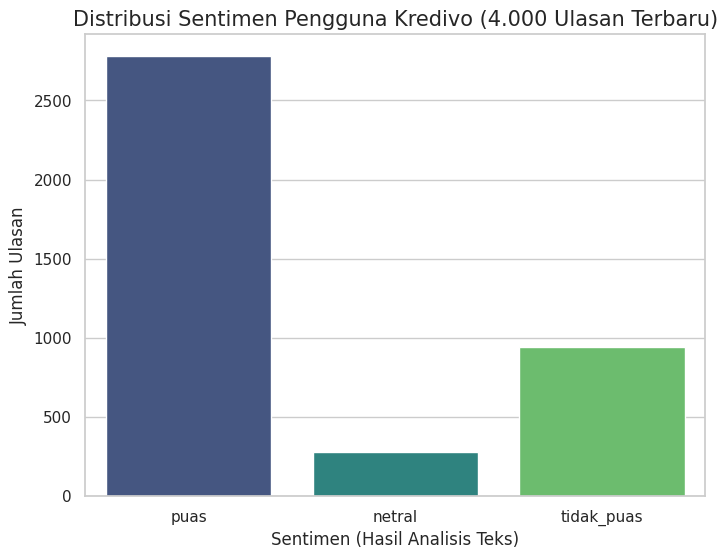

In [5]:
#Distribusi Sentimen:Melihat komposisi sentimen dari ulasan pengguna berdasarkan hasil sentimen teks.
import matplotlib.pyplot as plt
import seaborn as sns

# Atur tema visualisasi
sns.set_theme(style="whitegrid")

# Buat visualisasi
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen_teks', data=df, palette='viridis', order=['puas', 'netral', 'tidak_puas'])
plt.title('Distribusi Sentimen Pengguna Kredivo (4.000 Ulasan Terbaru)', fontsize=15)

plt.xlabel('Sentimen (Hasil Analisis Teks)')

plt.ylabel('Jumlah Ulasan')
plt.show()

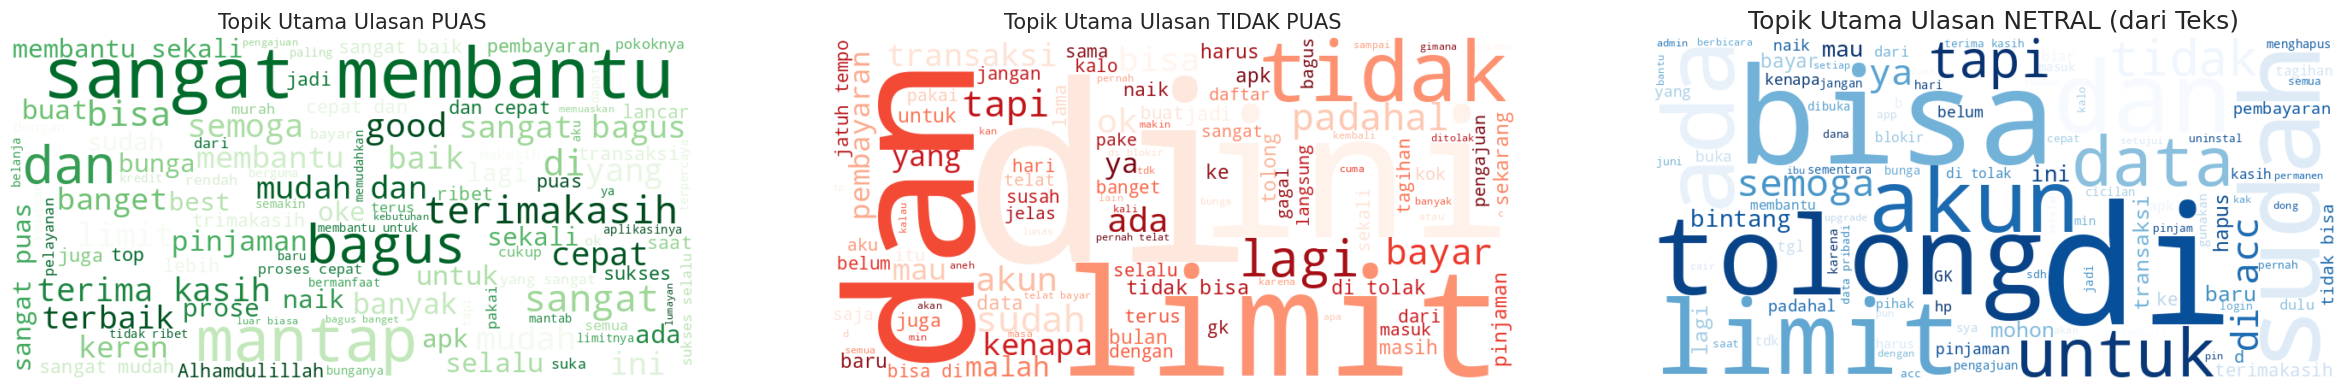

In [6]:
# Word Cloud (Awan Kata):Melihat kata kunci yang paling sering muncul pada ulasan yang puas dan tidak puas.
from wordcloud import WordCloud, STOPWORDS

# Siapkan stopwords (kata-kata umum yang diabaikan)
stopwords_indonesia = set(STOPWORDS)
stopwords_indonesia.update(["yg", "ga", "gak", "aja", "sih", "nya", "klo", "udh", "udah", "sy", "saya", "aplikasi", "kredivo"])

#Pisahkan ulasan berdasarkan tiga sentimen
ulasan_puas = " ".join(review for review in df[df['sentimen_teks'] == 'puas']['content'])
ulasan_tidak_puas = " ".join(review for review in df[df['sentimen_teks'] == 'tidak_puas']['content'])
ulasan_netral = " ".join(review for review in df[df['sentimen_teks'] == 'netral']['content'])

# Siapkan kanvas untuk 3 gambar, perlebar ukuran figurnya
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))


# Word Cloud untuk ulasan PUAS
wordcloud_puas = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Greens', max_words=100, width=800, height=400).generate(ulasan_puas)
ax1.imshow(wordcloud_puas, interpolation='bilinear')
ax1.set_title('Topik Utama Ulasan PUAS', fontsize=15)
ax1.axis("off")

# Word Cloud untuk ulasan NETRAL
wordcloud_netral = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Blues', max_words=100, width=800, height=400).generate(ulasan_netral)
ax3.imshow(wordcloud_netral, interpolation='bilinear')
ax3.set_title('Topik Utama Ulasan NETRAL (dari Teks)', fontsize=18)
ax3.axis("off")

# Word Cloud untuk ulasan TIDAK PUAS
wordcloud_tidak_puas = WordCloud(stopwords=stopwords_indonesia, background_color="white", colormap='Reds', max_words=100, width=800, height=400).generate(ulasan_tidak_puas)
ax2.imshow(wordcloud_tidak_puas, interpolation='bilinear')
ax2.set_title('Topik Utama Ulasan TIDAK PUAS', fontsize=15)
ax2.axis("off")

plt.show()

#Hasil Observasi Aplikasi Fintech: Kredivo
Objek Observasi: Aplikasi Kredivo di Google Play Store

Sumber Data: Ulasan dan rating pengguna

Jumlah Data: 4.000 ulasan terbaru

Metode Analisis: Sentimen ditentukan berdasarkan analisis teks ulasan menggunakan model AI untuk mendapatkan hasil yang lebih akurat dan kontekstual.

In [11]:
print("--- Jumlah Ulasan per Kategori Skor Bintang ---")

# Menghitung jumlah setiap nilai unik di kolom 'score'
# .sort_index() digunakan untuk mengurutkan hasilnya dari 1 sampai 5
jumlah_per_skor = df['score'].value_counts().sort_index()

print(jumlah_per_skor)

--- Jumlah Ulasan per Kategori Skor Bintang ---
score
1     498
2      87
3      95
4     170
5    3150
Name: count, dtype: int64


In [10]:
print("--- Persentase Sentimen Berdasarkan Kategori SKOR ---")

# Menghitung persentase untuk setiap nilai unik di kolom 'label_skor'
persentase_berdasarkan_skor = df['label_skor'].value_counts(normalize=True) * 100

# Menampilkan hasil dengan 2 angka di belakang koma
print(persentase_berdasarkan_skor.round(2))

--- Persentase Sentimen Berdasarkan Kategori SKOR ---
label_skor
puas          83.00
tidak_puas    14.62
netral         2.38
Name: proportion, dtype: float64


Berdasarkan analisis sentimen yang hanya mengandalkan pengelompokan*** rating bintang (skor)**, gambaran kepuasan pengguna aplikasi Kredivo terlihat sangat positif.

Dari data yang dianalisis, ditemukan bahwa:


1.   83.00% ulasan dikategorikan sebagai puas (berasal dari rating bintang 4 dan 5).
2.   14.62% ulasan yang tergolong tidak puas (berasal dari rating bintang 1 dan 2).

1.  2.38% dikategorikan sebagai netral (berasal dari rating bintang 3).


**Interpretasi Awal**:
Jika observasi berhenti di sini, kesimpulan yang akan ditarik adalah bahwa mayoritas absolut pengguna Kredivo merasa puas dengan layanan aplikasi.

#Observasi berdasasrkan Kuesioner

In [14]:
df_kue = pd.read_excel('/content/hasil_kuesioner_lengkap.xlsx')

df_kue.head()

,Nama (Inisial),Rentang Usia Anda?,Pekerjaan Anda saat ini?,Seberapa sering Anda menggunakan aplikasi ini dalam sebulan?,Untuk keperluan apa Anda paling sering menggunakan aplikasi ini?,Proses pendaftaran dan pengajuan di aplikasi ini mudah dan cepat.,Aplikasi ini sangat membantu saya dalam memenuhi kebutuhan finansial.,"Menurut saya, bunga dan/atau biaya layanan yang dikenakan cukup memberatkan.",Aplikasi ini berjalan dengan lancar dan jarang mengalami masalah teknis (error).,Saya merasa aman memberikan data pribadi saya pada aplikasi ini.,Apa fitur atau hal yang paling Anda sukai dari aplikasi ini?,Apa kendala atau hal paling tidak menyenangkan yang pernah Anda alami saat menggunakan aplikasi ini?,"Jika Anda bisa memberikan satu saran untuk perbaikan aplikasi ini, apakah itu?"
0,Among,> 30 tahun,Karyawan Swasta,Jarang (hanya saat butuh),"Belanja online (cicilan), Mendapatkan promo/di...",5,4,3,4,4,Banyak promo dan diskon di merchant favorit,Bunganya terasa sangat tinggi,Perbanyak lagi merchant yang bekerja sama
1,Irfan,> 30 tahun,Wiraswasta,Jarang (hanya saat butuh),"Mendapatkan promo/diskon, Membayar tagihan",4,5,4,2,3,Fitur cicilannya sangat membantu,Proses verifikasi kenaikan limit lama sekali,Layanan customer service perlu lebih responsif
2,Agnes,< 20 tahun,Karyawan Swasta,4-10 kali,Pinjaman tunai/dana darurat,5,4,2,4,4,"Prosesnya cepat dan mudah, tidak ribet",Aplikasi sering error pas mau bayar,Tingkatkan performa aplikasi agar tidak lemot
3,Kadir,26-30 tahun,Karyawan Swasta,Jarang (hanya saat butuh),"Belanja online (cicilan), Mendapatkan promo/di...",5,3,3,3,4,Banyak promo dan diskon di merchant favorit,Cara penagihan oleh DC kurang sopan,Layanan customer service perlu lebih responsif
4,Vivi,26-30 tahun,Karyawan Swasta,4-10 kali,Mendapatkan promo/diskon,5,3,1,2,3,Banyak promo dan diskon di merchant favorit,Aplikasi sering error pas mau bayar,Layanan customer service perlu lebih responsif


Analisis Kuantitatif

/tmp/ipython-input-15-272632539.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], y=df_kue['Rentang Usia Anda?'], palette='viridis')
/tmp/ipython-input-15-272632539.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], y=df_kue['Pekerjaan Anda saat ini?'], palette='plasma')


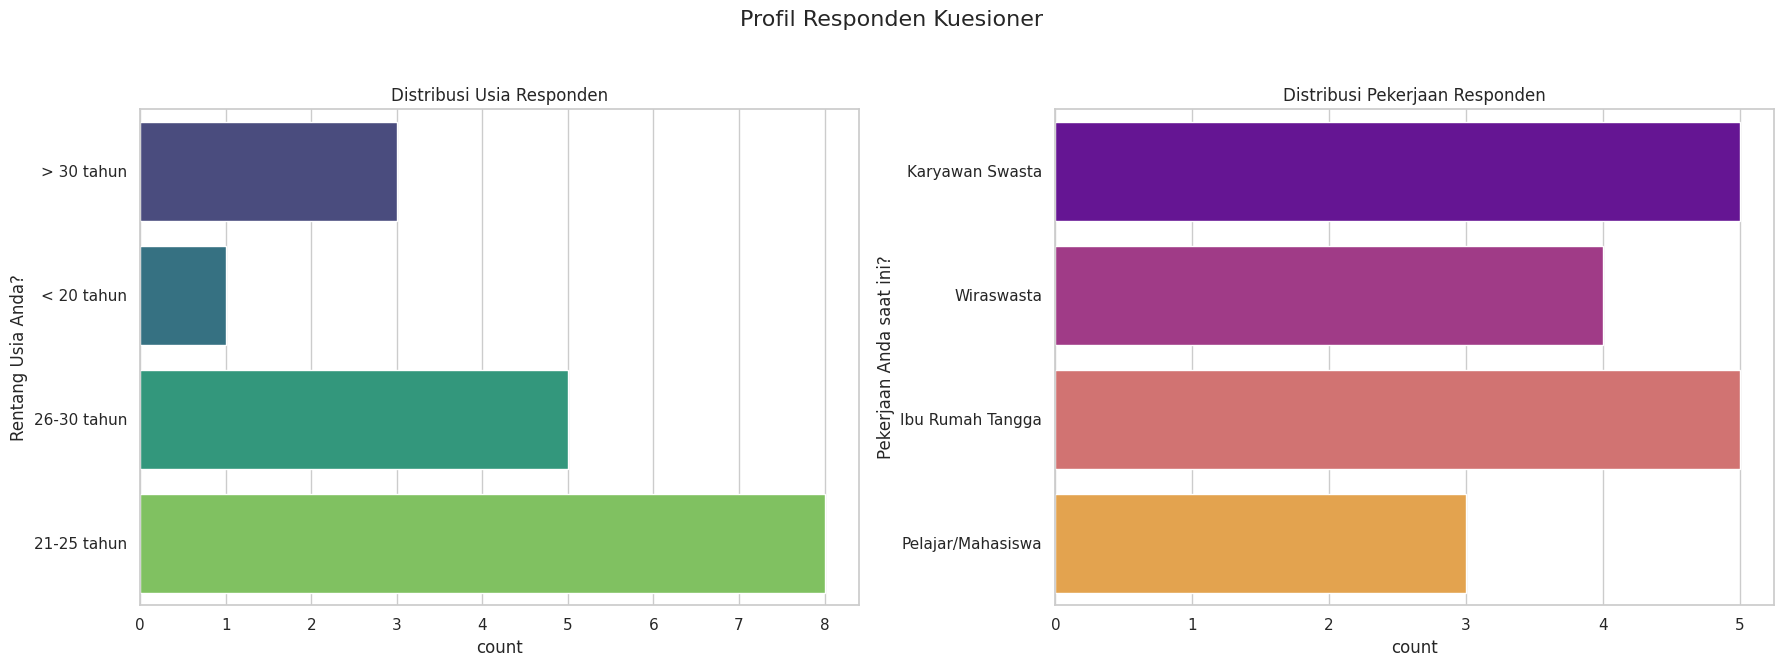

In [15]:
#Profil Responden

# Atur tema visualisasi
sns.set_theme(style="whitegrid")

# Siapkan kanvas untuk 2 grafik
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Profil Responden Kuesioner', fontsize=16)

# Grafik 1: Distribusi Usia
sns.countplot(ax=axes[0], y=df_kue['Rentang Usia Anda?'], palette='viridis')
axes[0].set_title('Distribusi Usia Responden')

# Grafik 2: Distribusi Pekerjaan
sns.countplot(ax=axes[1], y=df_kue['Pekerjaan Anda saat ini?'], palette='plasma')
axes[1].set_title('Distribusi Pekerjaan Responden')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Mayoritas pengguna aplikasi ini adalah kelompok dewasa muda.Kelompok usia yang paling dominan adalah 21-25 tahun, diikuti oleh kelompok usia 26-30 tahun.

Observasi: Ini mengindikasikan bahwa target pasar utama dan pengguna aktif adalah generasi milenial muda dan Gen Z yang sudah memasuki dunia kerja atau berada di awal karir mereka.

###

Profil pekerjaan pengguna sangat didominasi oleh Karyawan Swasta.

Jumlah responden dari kategori Wiraswasta dan Pelajar/Mahasiswa jauh lebih sedikit dibandingkan dengan Karyawan Swasta.

Observasi: Hal ini menunjukkan bahwa pengguna utama adalah individu yang kemungkinan besar memiliki pendapatan tetap setiap bulannya, yang membuat mereka menjadi target ideal untuk layanan finansial seperti cicilan atau pinjaman.



/tmp/ipython-input-16-1259841592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])


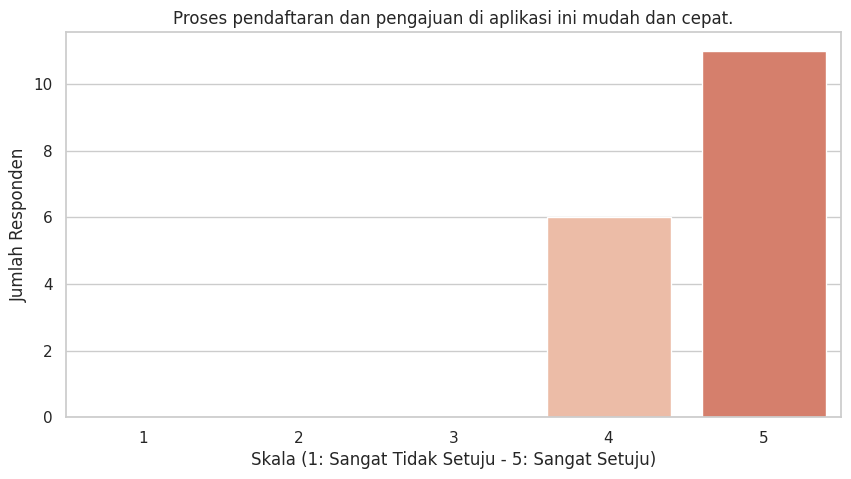

/tmp/ipython-input-16-1259841592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])


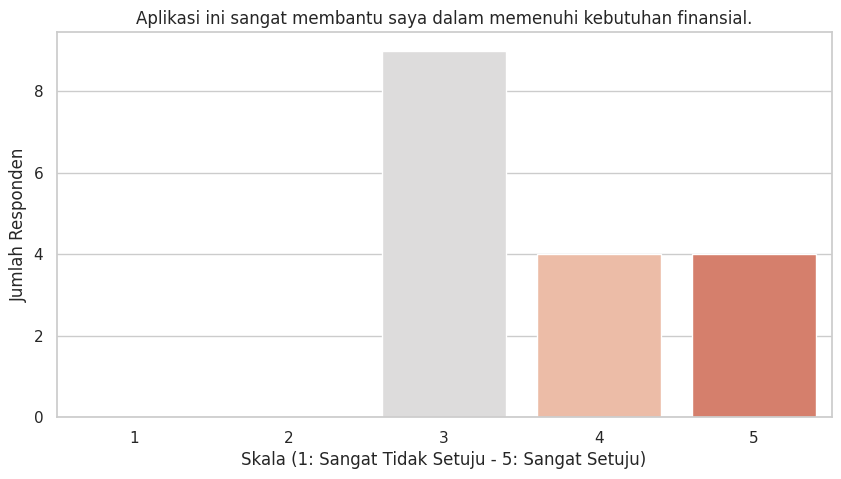

/tmp/ipython-input-16-1259841592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])


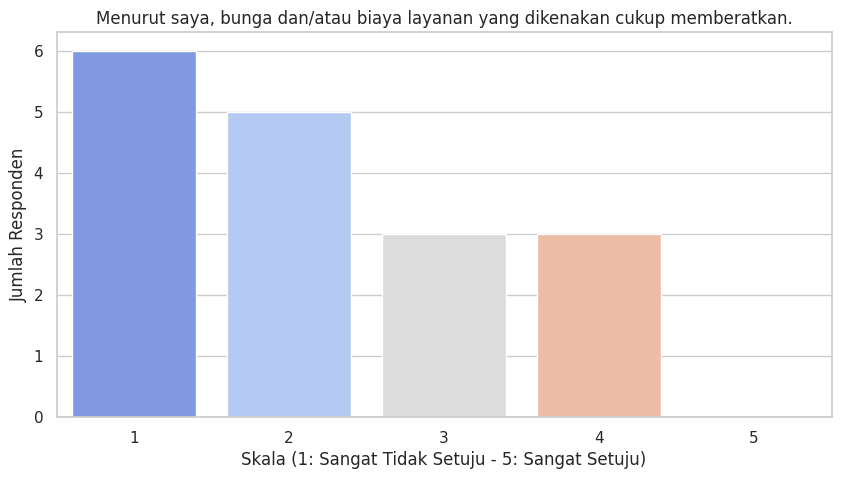

/tmp/ipython-input-16-1259841592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])


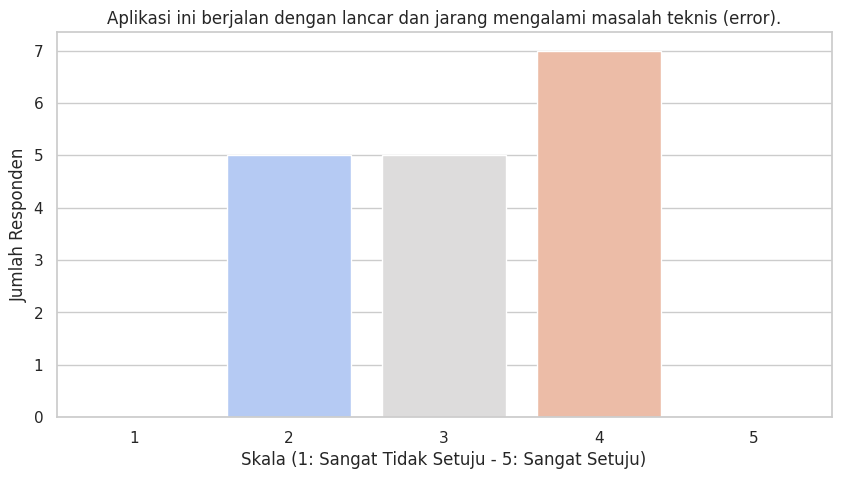

/tmp/ipython-input-16-1259841592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])


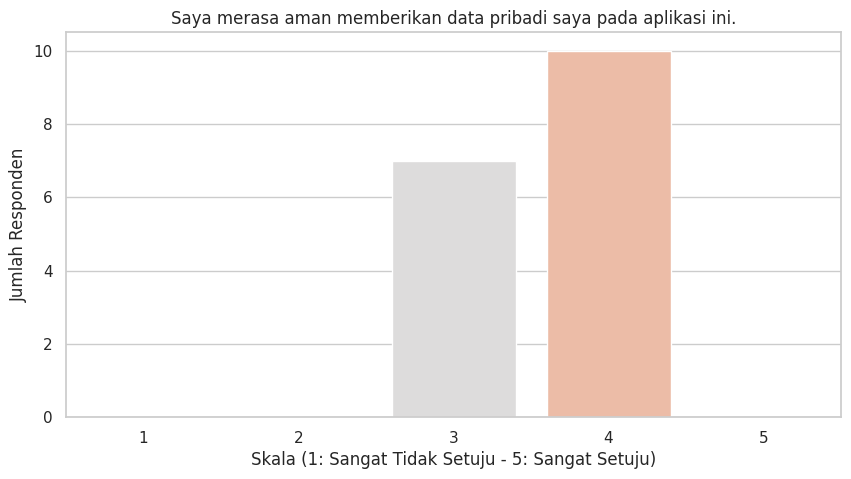

In [16]:
#  kolom yang berisi pertanyaan skala Likert
pertanyaan_likert = [
    "Proses pendaftaran dan pengajuan di aplikasi ini mudah dan cepat.",
    "Aplikasi ini sangat membantu saya dalam memenuhi kebutuhan finansial.",
    "Menurut saya, bunga dan/atau biaya layanan yang dikenakan cukup memberatkan.",
    "Aplikasi ini berjalan dengan lancar dan jarang mengalami masalah teknis (error).",
    "Saya merasa aman memberikan data pribadi saya pada aplikasi ini."
]

# Buat visualisasi untuk setiap pertanyaan
for pertanyaan in pertanyaan_likert:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df_kue[pertanyaan], palette='coolwarm', order=[1,2,3,4,5])
    plt.title(pertanyaan, fontsize=12)
    plt.xlabel('Skala (1: Sangat Tidak Setuju - 5: Sangat Setuju)')
    plt.ylabel('Jumlah Responden')
    plt.show()

Pengguna mengakui dan menyukai aplikasi ini karena kemudahan dan manfaatnya yang praktis. Namun, pengalaman positif tersebut secara signifikan dikurangi oleh biaya layanan yang dianggap tinggi. Selain itu, masalah stabilitas teknis dan keraguan akan keamanan data menjadi dua area penting lainnya yang perlu mendapat perhatian untuk meningkatkan kepercayaan dan kepuasan pengguna secara keseluruhan.

In [17]:
#Analisis Kualitatif

#  kolom pertanyaan terbuka
pertanyaan_terbuka = [
    "Apa fitur atau hal yang paling Anda sukai dari aplikasi ini?",
    "Apa kendala atau hal paling tidak menyenangkan yang pernah Anda alami saat menggunakan aplikasi ini?",
    "Jika Anda bisa memberikan satu saran untuk perbaikan aplikasi ini, apakah itu?"
]

# Tampilkan semua jawaban untuk setiap pertanyaan
for pertanyaan in pertanyaan_terbuka:
    print(f"--- Jawaban untuk: {pertanyaan} ---")
    # Menggunakan .tolist() untuk menampilkan semua jawaban dalam format list
    print(df_kue[pertanyaan].dropna().tolist())
    print("\n" + "="*50 + "\n")

--- Jawaban untuk: Apa fitur atau hal yang paling Anda sukai dari aplikasi ini? ---
['Banyak promo dan diskon di merchant favorit', 'Fitur cicilannya sangat membantu', 'Prosesnya cepat dan mudah, tidak ribet', 'Banyak promo dan diskon di merchant favorit', 'Banyak promo dan diskon di merchant favorit', 'Banyak promo dan diskon di merchant favorit', 'Banyak promo dan diskon di merchant favorit', 'Limitnya lumayan besar dan sangat berguna', 'Prosesnya cepat dan mudah, tidak ribet', 'Limitnya lumayan besar dan sangat berguna', 'Prosesnya cepat dan mudah, tidak ribet', 'Banyak promo dan diskon di merchant favorit', 'Fitur cicilannya sangat membantu', 'Prosesnya cepat dan mudah, tidak ribet', 'Limitnya lumayan besar dan sangat berguna', 'Prosesnya cepat dan mudah, tidak ribet', 'Fitur cicilannya sangat membantu']


--- Jawaban untuk: Apa kendala atau hal paling tidak menyenangkan yang pernah Anda alami saat menggunakan aplikasi ini? ---
['Bunganya terasa sangat tinggi', 'Proses verifikasi k

#Emphaty map

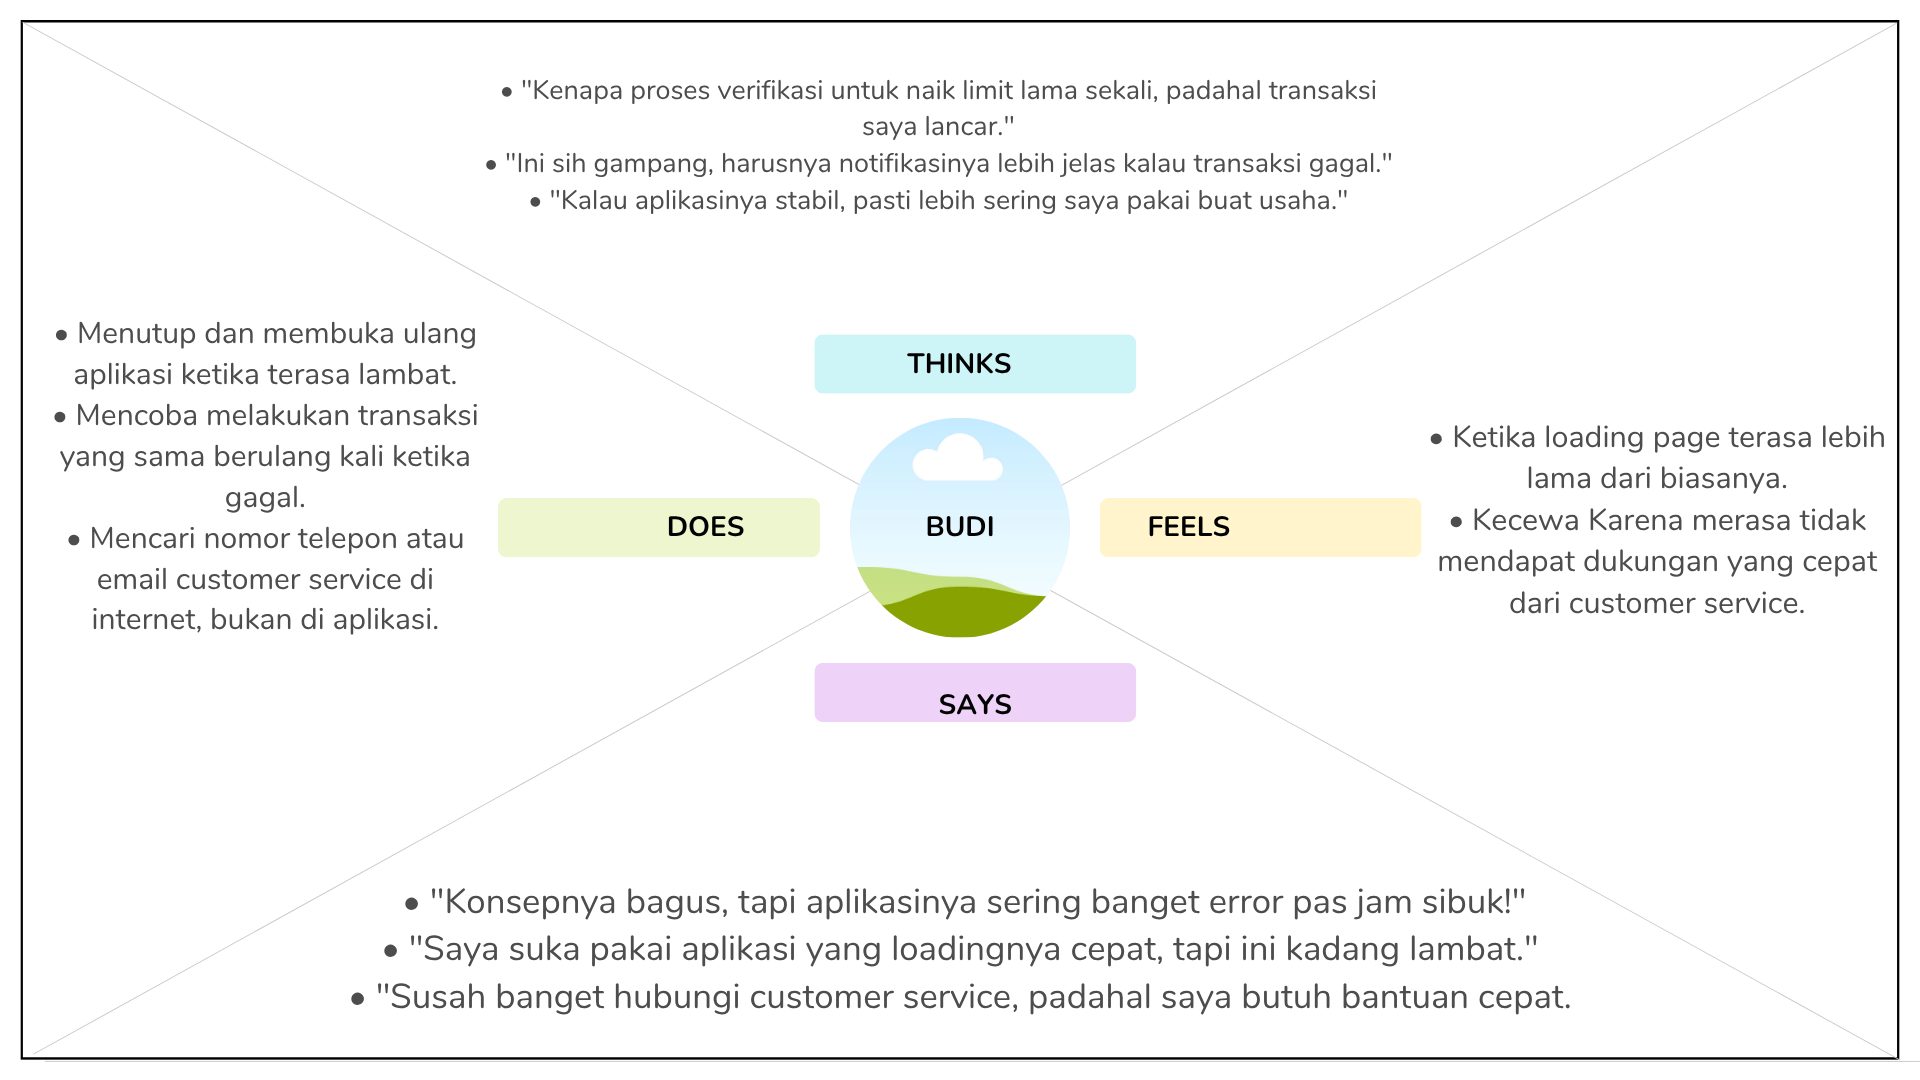

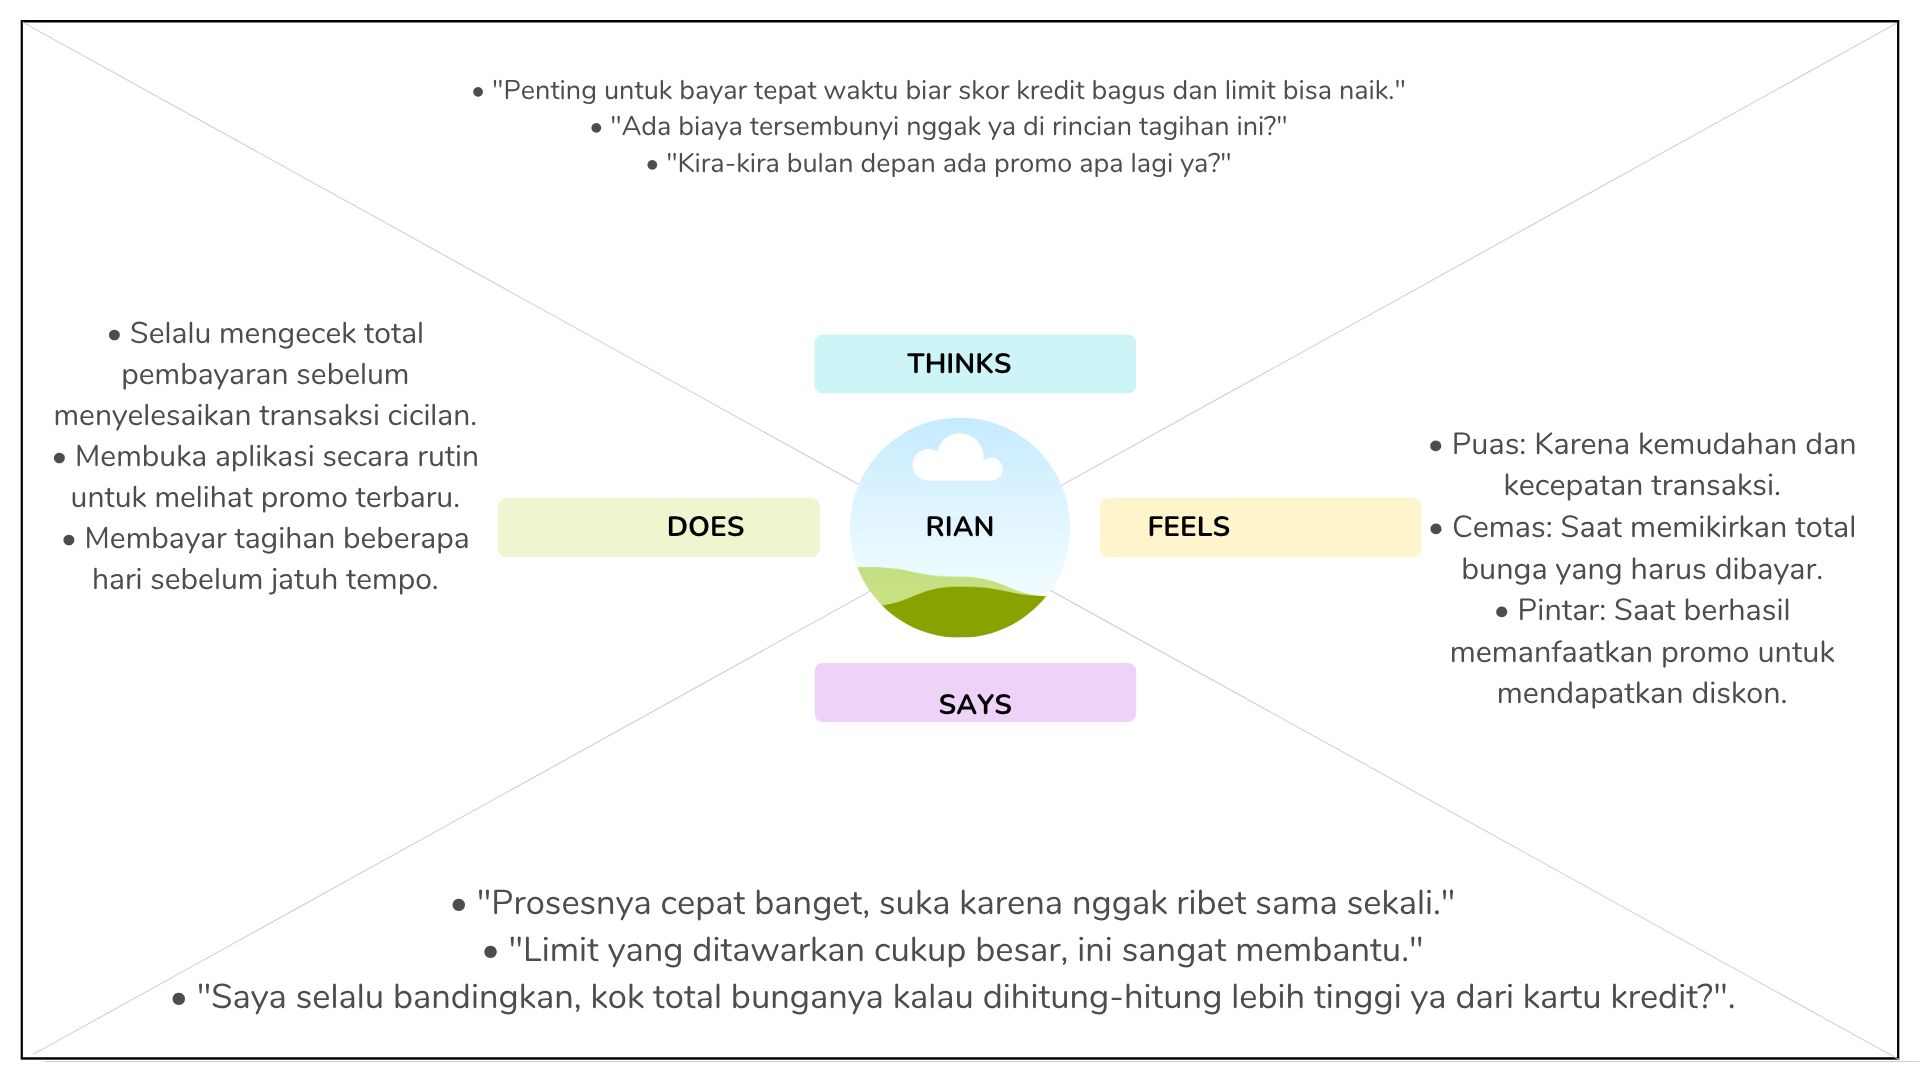

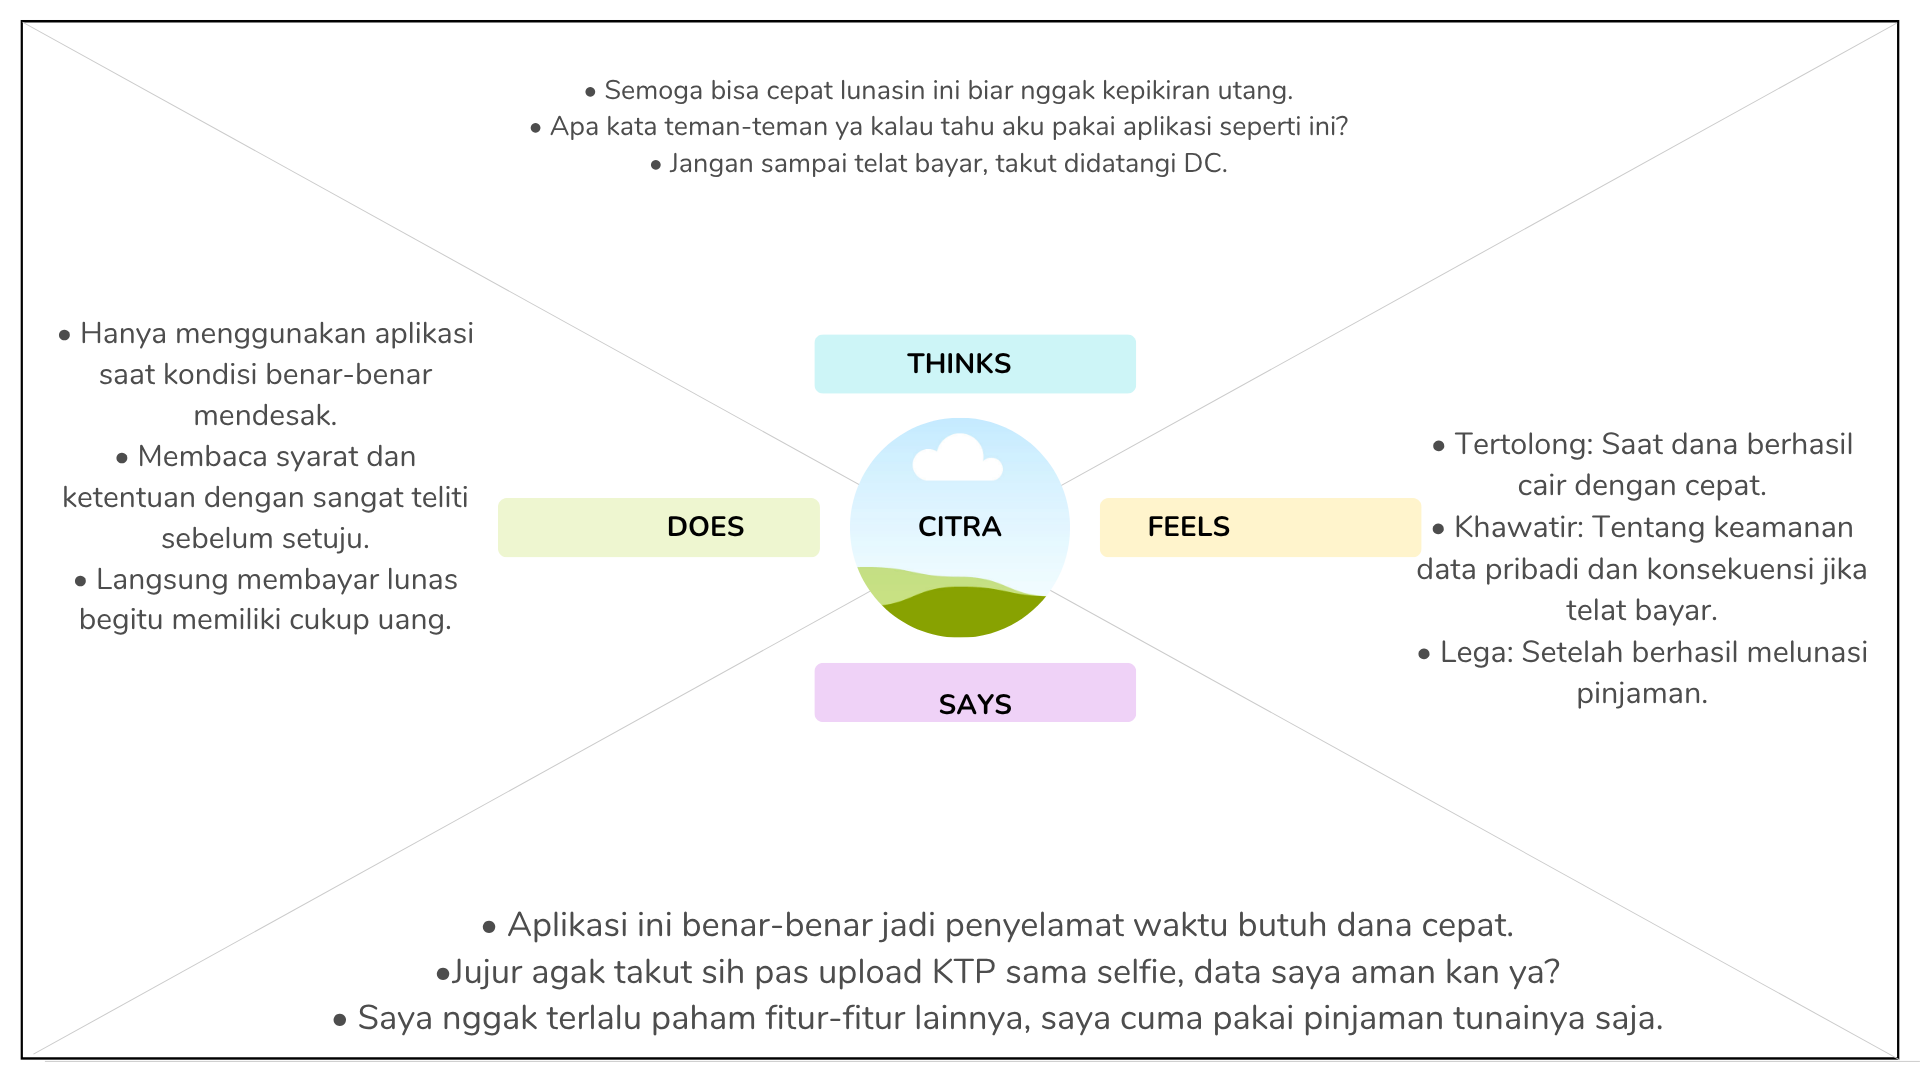

#How Might We

Dari semua analisis kita (analisis sentimen, kuesioner, dan persona), kita menemukan beberapa masalah dan kebutuhan utama pengguna Kredivo:



1. Masalah Biaya: Pengguna secara konsisten merasa bunga dan biaya layanan memberatkan dan tinggi.

2. Masalah Stabilitas Aplikasi: Pengguna frustrasi karena aplikasi sering error, lambat, dan tidak stabil, terutama saat transaksi penting.

3. Masalah Penagihan: Pengguna merasa cemas dan tidak nyaman dengan metode penagihan yang dianggap kurang sopan atau "menerror".

4. Masalah Layanan Pelanggan: Pengguna merasa kesulitan mendapatkan bantuan yang cepat dan responsif saat menghadapi masalah.

5. Kebutuhan Utama (Hal Positif): Pengguna sangat menghargai kecepatan dan kemudahan proses pengajuan.



##

berikut adalah rumusan pertanyaan "How Might We" yang diajukan untuk memicu ide-ide solusi inovatif:

1. **Bagaimana kita bisa menyajikan informasi biaya dan bunga secara lebih transparan agar pengguna merasa lebih tenang dan percaya saat akan bertransaksi?**  
   *Fokus:* Mengatasi masalah utama pengguna terkait biaya yang dianggap tinggi dan tidak terduga.

2. **Bagaimana kita bisa membuat proses pengingat dan penagihan tagihan yang lebih empatik dan manusiawi agar pengguna tidak merasa cemas atau diteror?**  
   *Fokus:* Mengatasi ketakutan dan pengalaman negatif pengguna seputar Debt Collector (DC) dan metode penagihan.

3. **Bagaimana kita bisa mengurangi kegagalan transaksi dan waktu tunggu (loading) agar pengalaman pengguna menjadi lebih lancar dan bebas hambatan?**  
   *Fokus:* Mengatasi frustrasi pengguna akibat aplikasi yang sering error dan lambat.

4. **Bagaimana kita bisa menyediakan dukungan pelanggan yang lebih cepat dan mudah diakses agar masalah pengguna dapat terselesaikan secara instan?**  
   *Fokus:* Mengatasi kesulitan pengguna dalam mendapatkan bantuan saat mereka membutuhkannya.


